# Валидация моделей

Рассмотрим этапы валидации модели на примере задачи обнаружения вредоносных ссылок.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn import set_config

set_config(display="diagram")

from scipy.stats import norm, ttest_ind
from scipy import stats

from xgboost import XGBClassifier

import shap

import warnings

warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))

import matplotlib.pyplot as plt
import seaborn as sns


Создаем окружение env

In [3]:
malicious_urls_dataset_url = "https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs/raw/master/data/data.csv"

ds = pd.read_csv(malicious_urls_dataset_url)
# ds = pd.read_csv('data.csv')
ds.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [4]:
ds["label"].value_counts()

label
good    344821
bad      75643
Name: count, dtype: int64

In [5]:
ds["label"].value_counts()/len(ds)*100

label
good    82.009637
bad     17.990363
Name: count, dtype: float64

In [6]:
len(ds)

420464

In [7]:
# Создание случайной выборки из 10% данных для дальнейшего анализа
ds_sample = ds.sample(frac=0.1, random_state=1)

In [8]:
# Приведение меток к числовому представлению (0 для good, 1 для bad)
ds_sample["label_enc"] = ds_sample.label.map({"bad": 1, "good": 0})

In [9]:
ds_sample.head(4)

,url,label,label_enc
155439,twitter.com/aQuariusrecOrds,good,0
152415,tong464.org/,good,0
276521,legacy.com/obituaries/orlandosentinel/obituary...,good,0
305692,natcath.org/ncr_onli.htm,good,0


In [10]:
# Определение столбцов для обучающих данных
feature_cols = "url"  # Столбец, содержащий URL адреса

# Целевой столбец для классификации
target_col = "label_enc"  # Столбец, содержащий метки классов

# Разделение исходных данных на признаки (X) и целевую переменную (y)
X = ds_sample[feature_cols]  # Выбор только столбца с URL адресами
y = ds_sample[target_col].values  # Извлечение значений целевой переменной

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)  # Разделение данных на обучающую (70%) и тестовую (30%) выборки с фиксированным seed для воспроизводимости

In [11]:
# Создание объекта CountVectorizer для векторизации URL адресов
url_vectorizer = CountVectorizer(
    analyzer="char",  # Анализатор для разбиения текста на символы
    ngram_range=(1, 1),  # Использование только биграмм (сочетаний из двух символов)
    # max_df=3,  # Максимальное количество документов для каждого признака (комментировано)
    # min_df=1,  # Минимальное количество документов для каждого признака (комментировано)
    # max_features=None,  # Максимальное количество признаков (комментировано)
)

# Создание объекта RandomForestClassifier для классификации
rf_clf = RandomForestClassifier(
    n_estimators=35,  # Количество деревьев в случайном лесу
    max_depth=9,  # Максимальная глубина каждого дерева
    random_state=42,  # Фиксированный seed для воспроизводимости
    n_jobs=1,  # Количество процессов для параллельной обработки
)

# Создание Pipeline для последовательного применения векторизации и классификации
pipe = Pipeline(
    steps=[
        ("vectorizer", url_vectorizer),  # Шаг векторизации URL адресов
        # ("todense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),  # Комментированный шаг преобразования в плотную матрицу (dense)
        ("classifier", rf_clf),  # Шаг классификации с помощью случайного леса
    ]
)
pipe

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='char')),
                ('classifier',
                 RandomForestClassifier(max_depth=9, n_estimators=35, n_jobs=1,
                                        random_state=42))])

In [12]:
# Обучение модели на обучающих данных
pipe.fit(X_train, y_train)

# Предсказание меток для тестовых данных
y_pred = pipe.predict(X_test)

# Вычисление точности, доля правильных предсказаний и F1-скоора
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

# Вычисление AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
roc_auc = roc_auc_score(y_test, y_pred)

# Вывод результатов
print(f"P: {P:.2f}, R: {R:.2f}, F1: {F1:.5f}, AUC: {roc_auc:.5f}")

P: 0.96, R: 0.21, F1: 0.34682, AUC: 0.60485


## Анализ 1

С помощью bootstrap постройте гистограмму распределения оценки $F_1$ на контрольной выборке.

Постройте теоретическое нормальное распределение на этой гистограмме.

Покажите среднее значение и стандартное отклонение.

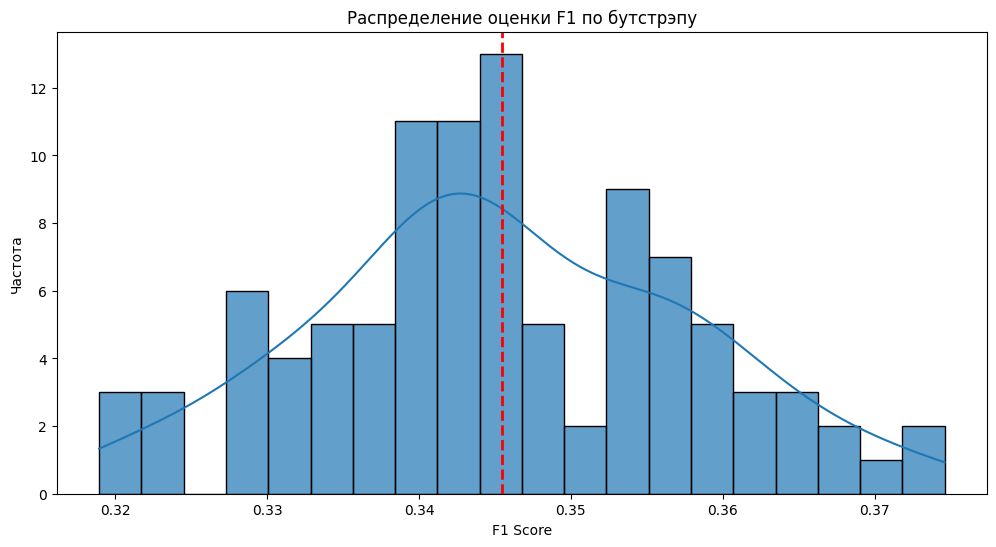

Среднее значение оценки F1: 0.3455
Стандартное отклонение оценки F1: 0.0123

Дополнительная информация о распределении:
Медиана: 0.3447
25-й процентиль: 0.3383
75-й процентиль: 0.3547


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Здесь устанавливается фиксированная семя для numpy, определяется количество итераций бутстрэпа (100). 
# Создаются DataFrames для исходных данных и результатов оценки.

np.random.seed(42)
bootstrap_iterations = 100

df = pd.DataFrame(
    data={
        "y_test": y_test,
        "y_pred": y_pred,
    }
)

scores = pd.DataFrame(
    data={"F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0}, index=range(bootstrap_iterations)
)

# Этот цикл выполняет бутстрэп для каждой метрики классификации (F1-score, точность, AUC ROC)
#  и сохраняет результаты в DataFrame.

for i in range(bootstrap_iterations):
    sample = df.sample(frac=1.0, replace=True)
    scores.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=scores["F1"], kde=True, bins=20, edgecolor="black", alpha=0.7, ax=ax)
F1_mean = np.mean(scores["F1"])
ax.axvline(x=F1_mean, color="red", linestyle="dashed", linewidth=2)

plt.title("Распределение оценки F1 по бутстрэпу")
plt.xlabel("F1 Score")
plt.ylabel("Частота")
plt.show()

print(f"Среднее значение оценки F1: {np.mean(scores['F1']):.4f}")
print(f"Стандартное отклонение оценки F1: {np.std(scores['F1']):.4f}")

# Дополнительная информация о распределении
print("\nДополнительная информация о распределении:")
print(f"Медиана: {np.median(scores['F1']):.4f}")
print(f"25-й процентиль: {np.percentile(scores['F1'], 25):.4f}")
print(f"75-й процентиль: {np.percentile(scores['F1'], 75):.4f}")

#### Анализ помогает проанализировать стабильность модели классификации, используя метод бутстрэпа, и предоставляет наглядную информацию о распределении оценки F1-score.

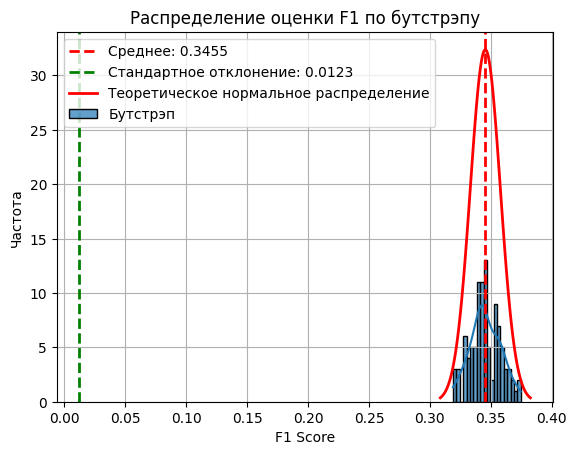

Среднее значение оценки F1: 0.3455
Стандартное отклонение оценки F1: 0.0123

Дополнительная информация о распределении:
Медиана: 0.3447
25-й процентиль: 0.3383
75-й процентиль: 0.3547


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

np.random.seed(42)
bootstrap_iterations = 100

df = pd.DataFrame(
    data={
        "y_test": y_test,
        "y_pred": y_pred,
    }
)

scores = pd.DataFrame(
    data={"F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0}, index=range(bootstrap_iterations)
)

# Вычисление метрик для каждой итерации бутстрэпа
for i in range(bootstrap_iterations):
    sample = df.sample(frac=1.0, replace=True)
    
    f1 = f1_score(sample["y_test"], sample["y_pred"])
    p = precision_score(sample["y_test"], sample["y_pred"])
    r = recall_score(sample["y_test"], sample["y_pred"])
    auc = roc_auc_score(sample["y_test"], sample["y_pred"])
    
    scores.loc[i, ["F1", "P", "R", "AUC"]] = [f1, p, r, auc]

# Построение гистограммы распределения оценки F1 с использованием Seaborn
ax = sns.histplot(scores['F1'], kde=True, bins=20, edgecolor='black', alpha=0.7, label='Бутстрэп')
plt.axvline(np.mean(scores['F1']), color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {np.mean(scores["F1"]):.4f}')
plt.axvline(np.std(scores['F1']), color='green', linestyle='dashed', linewidth=2, label=f'Стандартное отклонение: {np.std(scores["F1"]):.4f}')

# Теоретическое нормальное распределение
mu, sigma = np.mean(scores['F1']), np.std(scores['F1'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Теоретическое нормальное распределение')

plt.title('Распределение оценки F1 по бутстрэпу')
plt.xlabel('F1 Score')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()

print(f"Среднее значение оценки F1: {np.mean(scores['F1']):.4f}")
print(f"Стандартное отклонение оценки F1: {np.std(scores['F1']):.4f}")

# Дополнительная информация о распределении
print("\nДополнительная информация о распределении:")
print(f"Медиана: {np.median(scores['F1']):.4f}")
print(f"25-й процентиль: {np.percentile(scores['F1'], 25):.4f}")
print(f"75-й процентиль: {np.percentile(scores['F1'], 75):.4f}")


### Часть вторая 

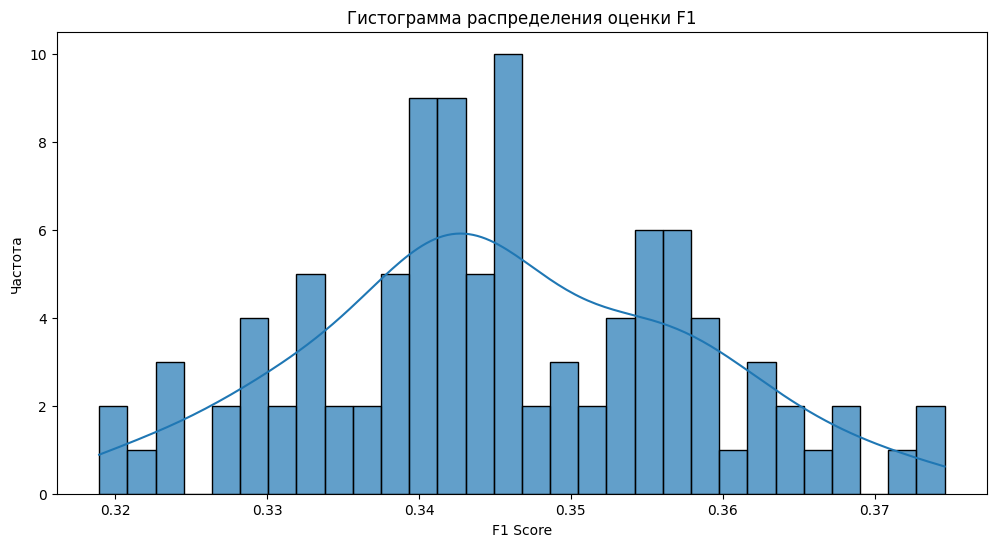

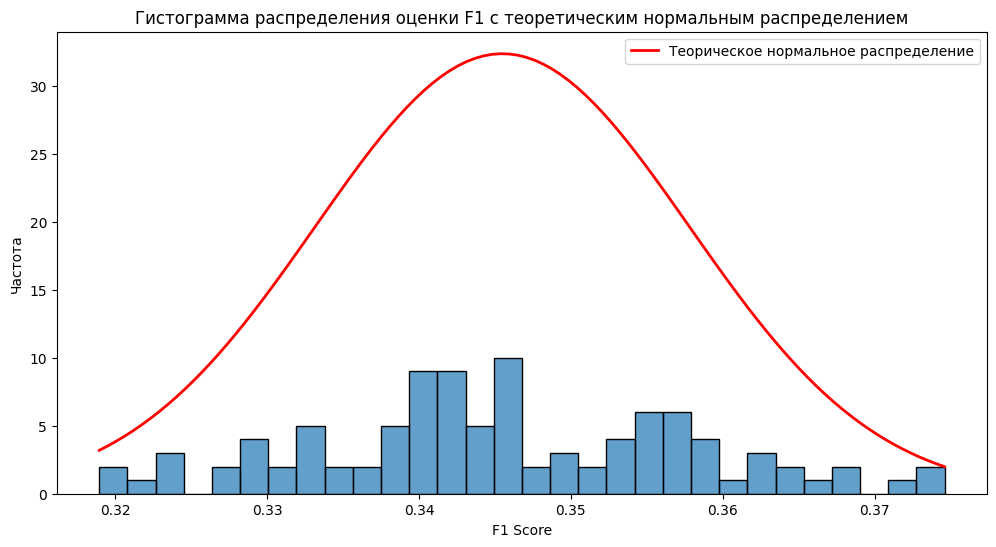

Среднее значение оценки F1: 0.3455
Стандартное отклонение оценки F1: 0.0123


In [15]:
f1_mean = scores["F1"].mean()
f1_std = scores["F1"].std()

#  Вычисляем среднее значение и стандартное отклонение для оценки F1.
# Затем определяем нижнюю и верхнюю границы, используя правило трех сигм (3σ),
# что часто используется для определения значительных отклонений.

f1_low = f1_mean - 3 * f1_std
f1_upp = f1_mean + 3 * f1_std

# Построение гистограммы распределения оценки F1
# Cоздаеv гистограмму распределения оценки F1. Используем библиотеку seaborn для построения графика и включаем
#  кривую плотности (кDE) для лучшего представления распределения.

plt.figure(figsize=(12, 6))
sns.histplot(data=scores["F1"], kde=True, bins=30, edgecolor="black", alpha=0.7)
plt.title("Гистограмма распределения оценки F1")
plt.xlabel("F1 Score")
plt.ylabel("Частота")
plt.show()

# Построение теоретического нормального распределения
# Добавляем линию теоретического нормального распределения. 
# Это позволяет сравнить реальное распределение с идеализированным нормальным распределением.

x_theor = np.linspace(min(scores["F1"]), max(scores["F1"]), 100)
mu = np.mean(scores["F1"])
sigma = np.std(scores["F1"])
y_theor = stats.norm.pdf(x_theor, mu, sigma)

plt.figure(figsize=(12, 6))
sns.histplot(data=scores["F1"], kde=False, bins=30, edgecolor="black", alpha=0.7)
plt.plot(x_theor, y_theor, "r-", lw=2, label="Теорическое нормальное распределение")
plt.title(
    "Гистограмма распределения оценки F1 с теоретическим нормальным распределением"
)
plt.xlabel("F1 Score")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Вывод среднего значения и стандартного отклонения
# Выводим среднее значение и стандартное отклонение оценки F1 с четырьмя знаками после запятой для точности.

print(f"Среднее значение оценки F1: {np.mean(scores['F1']):.4f}")
print(f"Стандартное отклонение оценки F1: {np.std(scores['F1']):.4f}")

##### Анализ помогает лучше понять распределение оценки F1, выявляя закономерности и аномалии в данных. Он также предоставляет количественные характеристики распределения, которые могут быть полезны для дальнейшего анализа или интерпретации результатов модели.

## Подбор гипрепараметров

In [16]:
params_grid = {
    "classifier__n_estimators": range(50, 70, 10),
    "classifier__max_depth": range(15, 20),
}

random_search_res = RandomizedSearchCV(
    pipe,
    params_grid,
    n_iter=100,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42,
).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [17]:
random_search_res.best_params_

{'classifier__n_estimators': 60, 'classifier__max_depth': 19}

In [18]:
y_pred_candidate = random_search_res.predict(X_test)
P_candidate, R_candidate, F1_candidate, _ = precision_recall_fscore_support(
    y_test, y_pred_candidate, average="binary"
)
print(
    f"P_candidate: {P_candidate:.2f}, R_candidate: {R_candidate:.2f}, F1_candidate: {F1_candidate:.5f}"
)

P_candidate: 0.93, R_candidate: 0.43, F1_candidate: 0.59184


## Анализ 2

1. Построем с помощью booststrap выборку оценки $F_1$ для лучшей модели после подбора гиперпарамтеров.

In [19]:


df_cand = pd.DataFrame(
    data={
        "y_test": y_test,
        "y_pred": y_pred_candidate,
    }
)

scores_cand = pd.DataFrame(
    data={"F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0}, index=range(bootstrap_iterations)
)

# Выполнение bootstrap для оценки F1-score лучшей модели после подбора гиперпараметров
for i in range(bootstrap_iterations):
    sample = df_cand.sample(frac=1.0, replace=True)
    scores_cand.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])



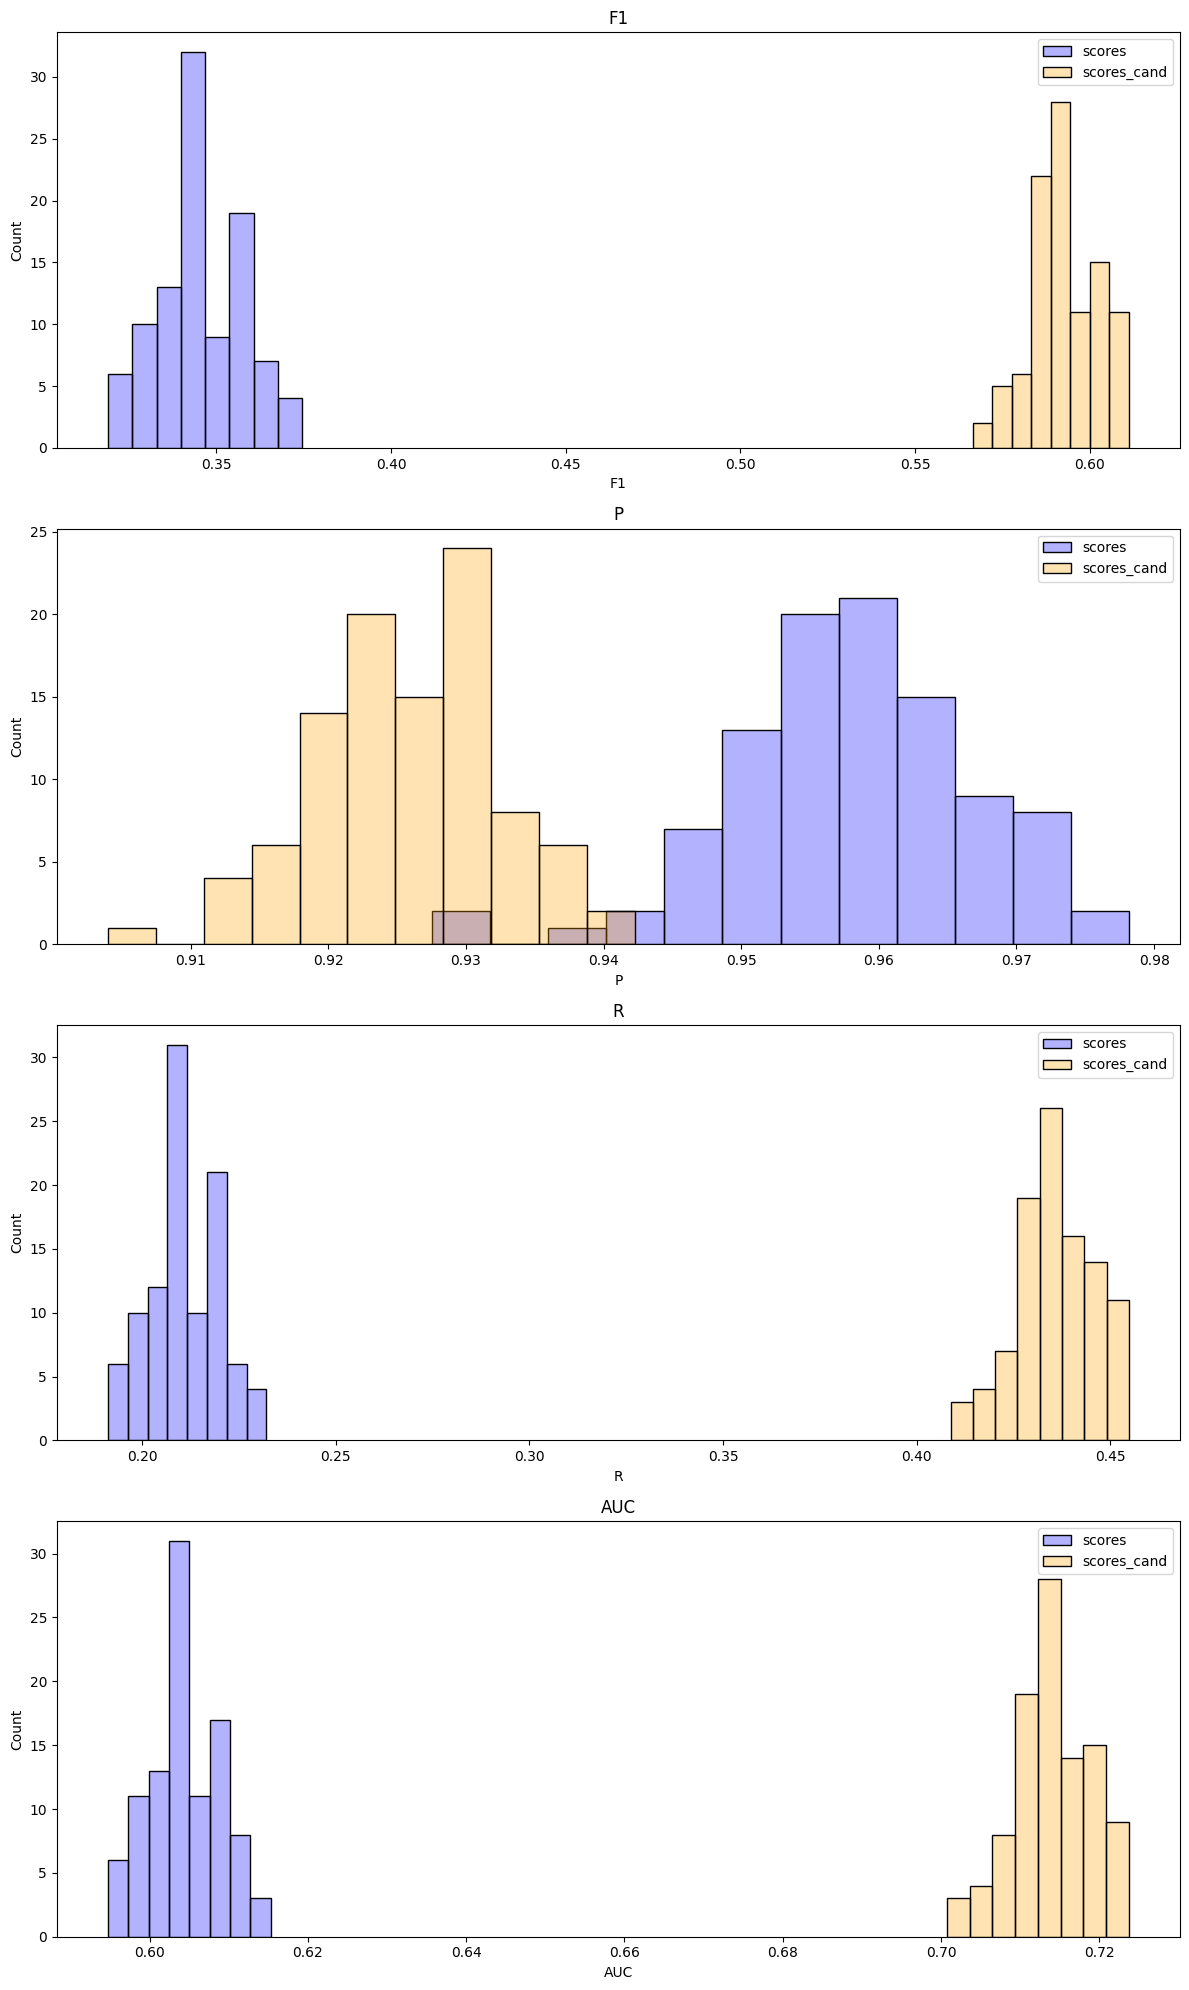

In [20]:
# Определение столбцов для визуализации
columns_to_plot = ["F1", "P", "R", "AUC"]

# Создание фигуры и осей
fig, axes = plt.subplots(
    len(columns_to_plot), 1, figsize=(12, 5 * len(columns_to_plot))
)

# Визуализация метрик
for i, column in enumerate(columns_to_plot):
    sns.histplot(
        data=scores, x=column, ax=axes[i], color="blue", label="scores", alpha=0.3
    )
    sns.histplot(
        data=scores_cand,
        x=column,
        ax=axes[i],
        color="orange",
        label="scores_cand",
        alpha=0.3,
    )

    # Добавление легенды
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"{column}")

    axes[i].legend()

plt.tight_layout()

plt.show()

##### Этот код создает графики гистограмм для всех четырех метрик (F1, P, R, AUC) из обоих наборов данных (scores и scores_cand). Каждая график показывает распределение оценок для конкретной метрики, используя синий цвет для базового набора данных и оранжевый цвет для кандидатного набора данных. Графики имеют одинаковый размер и расположены друг под другом в одной строке.

##### Улучшенный вариант

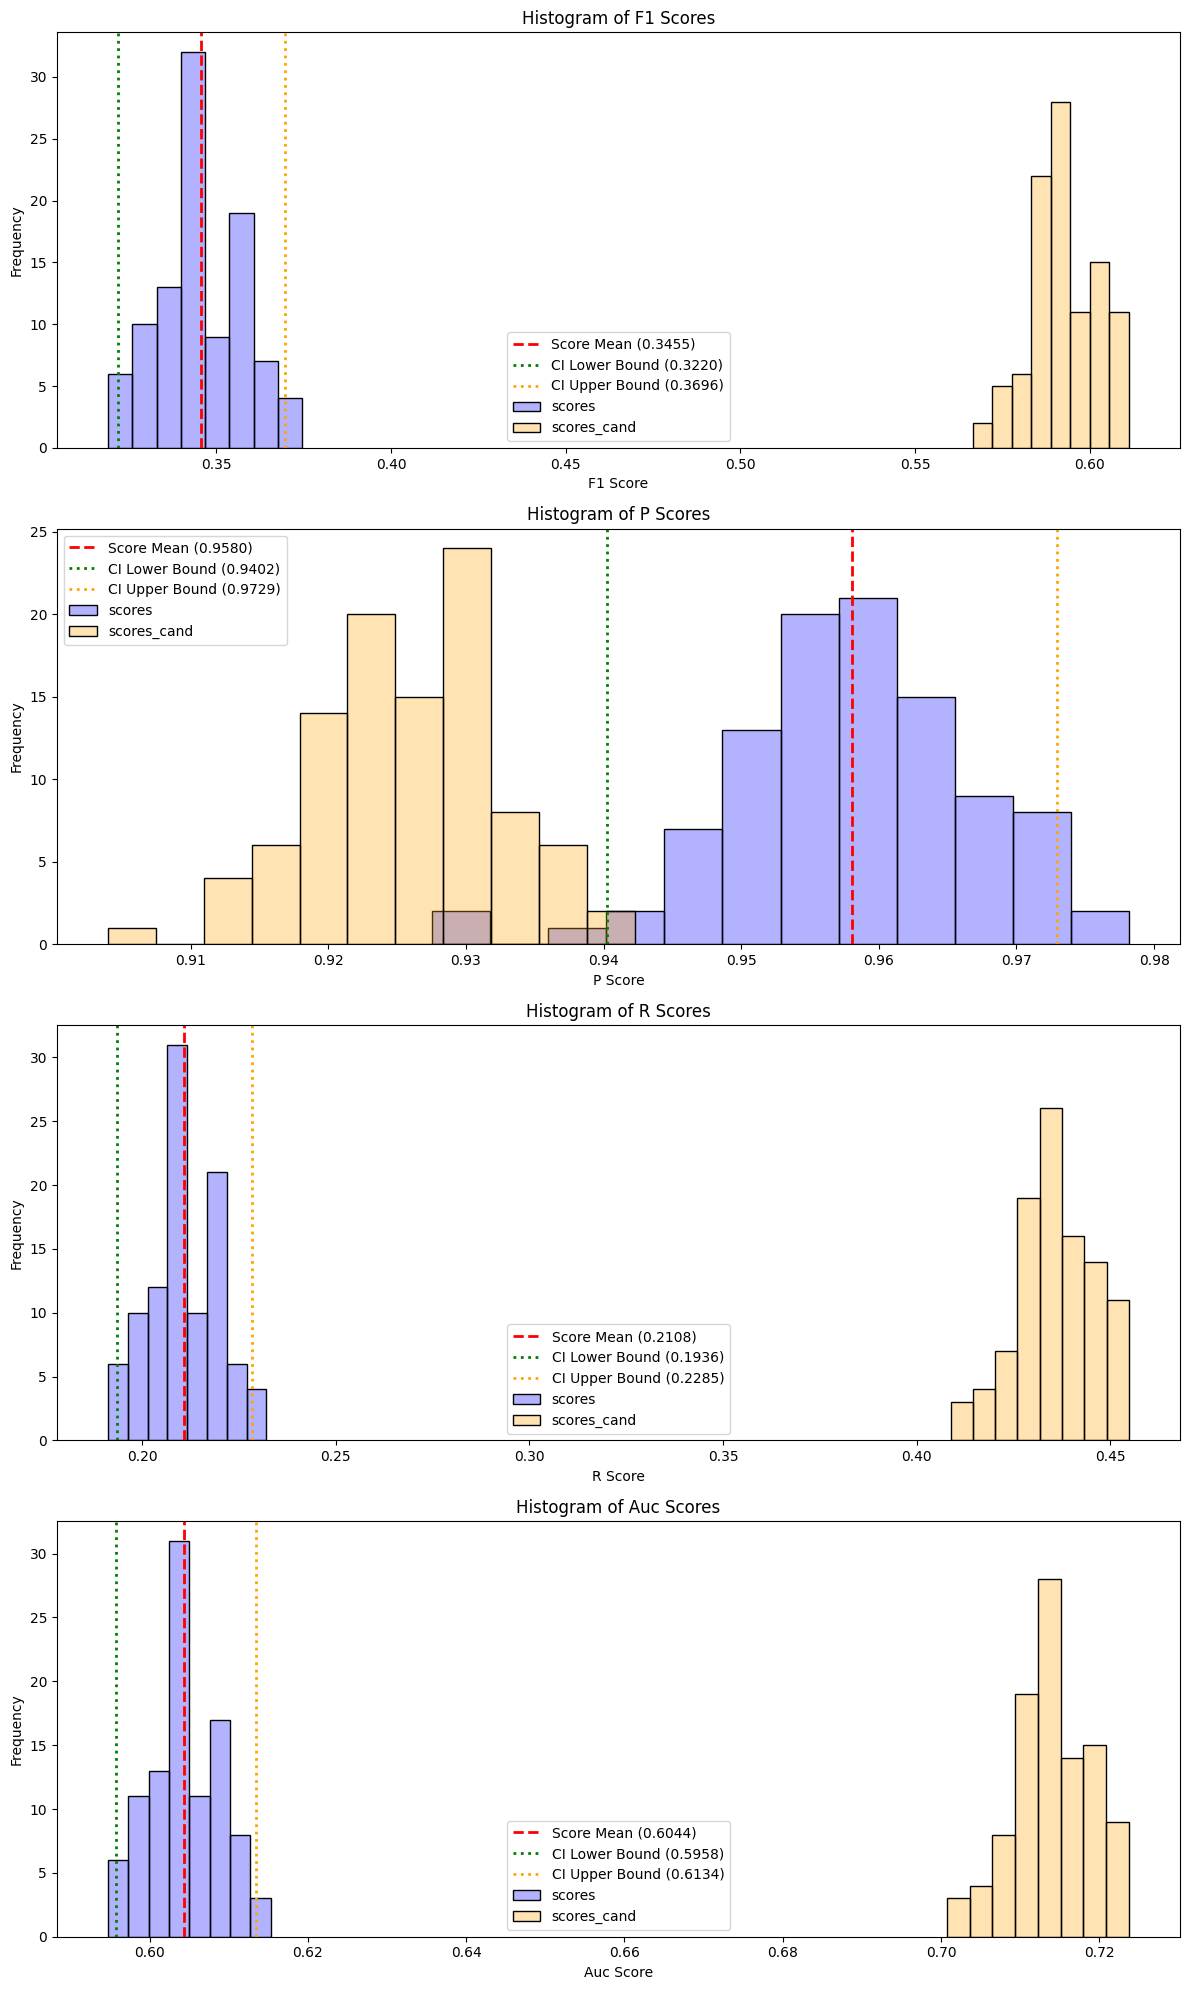


Сравнение средних значений и доверительных интервалов:

F1 Score Comparison:
F1:
Score Mean: 0.3455
Score Candidate Mean: 0.5925
Difference: 0.2470
95% CI Score: [0.3220, 0.3696]
95% CI Score Candidate: [0.5726, 0.6076]

P Score Comparison:
P:
Score Mean: 0.9580
Score Candidate Mean: 0.9257
Difference: -0.0324
95% CI Score: [0.9402, 0.9729]
95% CI Score Candidate: [0.9113, 0.9381]

R Score Comparison:
R:
Score Mean: 0.2108
Score Candidate Mean: 0.4357
Difference: 0.2249
95% CI Score: [0.1936, 0.2285]
95% CI Score Candidate: [0.4145, 0.4531]

Auc Score Comparison:
AUC:
Score Mean: 0.6044
Score Candidate Mean: 0.7141
Difference: 0.1097
95% CI Score: [0.5958, 0.6134]
95% CI Score Candidate: [0.7036, 0.7223]


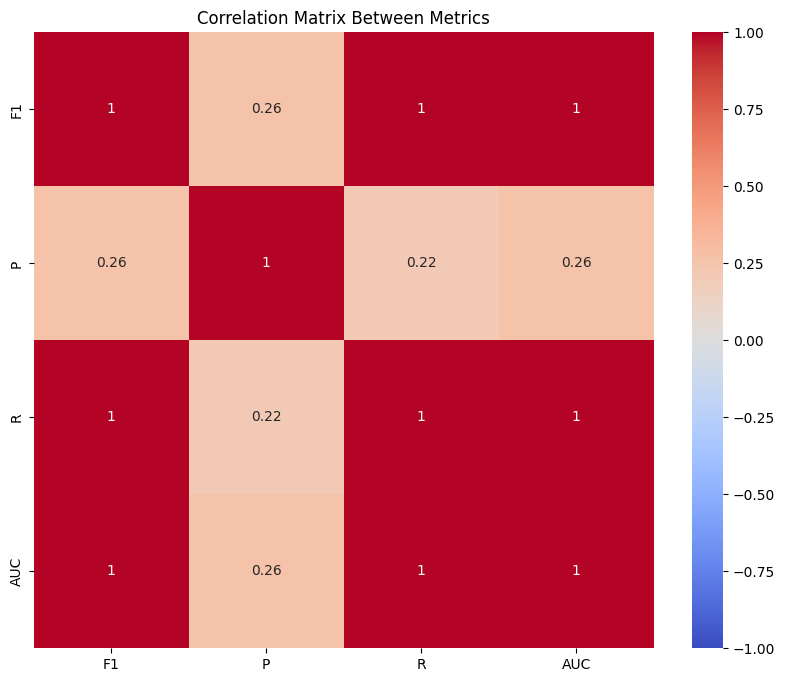


Statistical Measures of Distribution:

Distribution Analysis for F1:
Mean: 0.3455
Standard Deviation: 0.0124
Median: 0.3447
25th Percentile: 0.3383
75th Percentile: 0.3547
Skewness: 0.0857
Kurtosis: -0.3900

Distribution Analysis for P:
Mean: 0.9580
Standard Deviation: 0.0088
Median: 0.9584
25th Percentile: 0.9529
75th Percentile: 0.9629
Skewness: -0.5231
Kurtosis: 1.0781

Distribution Analysis for R:
Mean: 0.2108
Standard Deviation: 0.0091
Median: 0.2103
25th Percentile: 0.2054
75th Percentile: 0.2176
Skewness: 0.0988
Kurtosis: -0.3906

Distribution Analysis for AUC:
Mean: 0.6044
Standard Deviation: 0.0046
Median: 0.6041
25th Percentile: 0.6017
75th Percentile: 0.6078
Skewness: 0.1220
Kurtosis: -0.3804


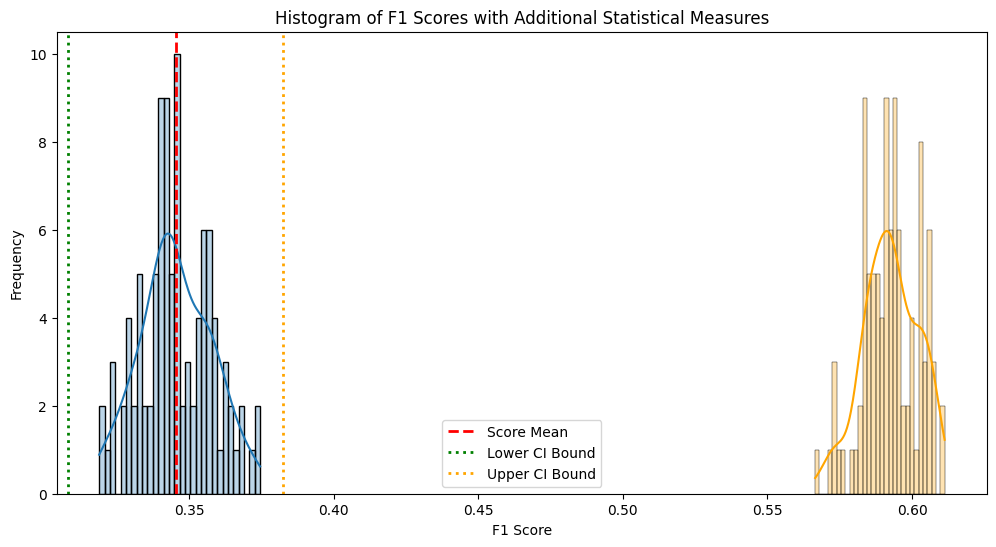

In [21]:
import numpy as np
from scipy import stats

# Определение столбцов для визуализации
columns_to_plot = ["F1", "P", "R", "AUC"]

# Создание фигуры и осей
fig, axes = plt.subplots(
    len(columns_to_plot), 1, figsize=(12, 5 * len(columns_to_plot))
)

# Визуализация метрик
for i, column in enumerate(columns_to_plot):
    sns.histplot(
        data=scores, x=column, ax=axes[i], color="blue", label="scores", alpha=0.3
    )
    sns.histplot(
        data=scores_cand,
        x=column,
        ax=axes[i],
        color="orange",
        label="scores_cand",
        alpha=0.3,
    )

    # Добавление легенды
    axes[i].legend(loc="upper right")

    # Добавление вертикальной линии для среднего значения
    mean_value = scores[column].mean()
    axes[i].axvline(
        mean_value,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Score Mean ({mean_value:.4f})",
    )

    # Добавление вертикальной линии для доверительного интервала
    ci_lower = np.percentile(scores[column], 2.5)
    ci_upper = np.percentile(scores[column], 97.5)
    axes[i].axvline(
        ci_lower,
        color="green",
        linestyle="dotted",
        linewidth=2,
        label=f"CI Lower Bound ({ci_lower:.4f})",
    )
    axes[i].axvline(
        ci_upper,
        color="orange",
        linestyle="dotted",
        linewidth=2,
        label=f"CI Upper Bound ({ci_upper:.4f})",
    )

    # Настройка заголовков и меток осей
    axes[i].set_title(f"Histogram of {column.capitalize()} Scores")
    axes[i].set_xlabel(column.capitalize() + " Score")
    axes[i].set_ylabel("Frequency")

    # Добавление легенды
    axes[i].legend()

# Настройка общего форматирования фигуры
plt.tight_layout()
plt.show()

# Сравнение средних значений и доверительных интервалов
print("\nСравнение средних значений и доверительных интервалов:")
for metric in columns_to_plot:
    print(f"\n{metric.capitalize()} Score Comparison:")
    print(f"{metric}:")
    print(f"Score Mean: {scores[metric].mean():.4f}")
    print(f"Score Candidate Mean: {scores_cand[metric].mean():.4f}")
    print(f"Difference: {scores_cand[metric].mean() - scores[metric].mean():.4f}")

    ci_lower = np.percentile(scores[metric], 2.5)
    ci_upper = np.percentile(scores[metric], 97.5)
    ci_candidate_lower = np.percentile(scores_cand[metric], 2.5)
    ci_candidate_upper = np.percentile(scores_cand[metric], 97.5)

    print(f"95% CI Score: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(
        f"95% CI Score Candidate: [{ci_candidate_lower:.4f}, {ci_candidate_upper:.4f}]"
    )

# Корреляционная матрица между метриками
correlation_matrix = pd.DataFrame(
    {"F1": scores["F1"], "P": scores["P"], "R": scores["R"], "AUC": scores["AUC"]}
).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Between Metrics")
plt.show()

# Статистические показатели распределения
print("\nStatistical Measures of Distribution:")
for metric in columns_to_plot:
    print(f"\nDistribution Analysis for {metric}:")
    print(f"Mean: {scores[metric].mean():.4f}")
    print(f"Standard Deviation: {scores[metric].std():.4f}")
    print(f"Median: {np.median(scores[metric]):.4f}")
    print(f"25th Percentile: {np.percentile(scores[metric], 25):.4f}")
    print(f"75th Percentile: {np.percentile(scores[metric], 75):.4f}")
    print(f"Skewness: {stats.skew(scores[metric]):.4f}")
    print(f"Kurtosis: {stats.kurtosis(scores[metric]):.4f}")

# Визуализация распределения F1 с дополнительными статистическими показателями
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=scores["F1"], kde=True, bins=30, edgecolor="black", alpha=0.3, ax=ax)
sns.histplot(
    data=scores_cand["F1"], kde=True, bins=30, color="orange", alpha=0.3, ax=ax
)
mean_value = scores["F1"].mean()
std_value = scores["F1"].std()
ax.axvline(
    x=mean_value, color="red", linestyle="dashed", linewidth=2, label="Score Mean"
)
ax.axvline(
    x=mean_value - 3 * std_value,
    color="green",
    linestyle="dotted",
    linewidth=2,
    label="Lower CI Bound",
)
ax.axvline(
    x=mean_value + 3 * std_value,
    color="orange",
    linestyle="dotted",
    linewidth=2,
    label="Upper CI Bound",
)
ax.legend()
ax.set_title("Histogram of F1 Scores with Additional Statistical Measures")
ax.set_xlabel("F1 Score")
ax.set_ylabel("Frequency")
plt.show()

2. Сравним с помощью t-теста базовую модель и кандидата. Примите $\alpha = 0.01$


In [22]:
alpha = 0.001

for name in ["F1", "P"]:
    pvalue = ttest_ind(scores[name], scores_cand[name]).pvalue

    print(f"p-value ({name}): {pvalue:g}", end="\t")
    if pvalue < alpha:
        print(" Reject null hypothesis.")
    else:
        print(" Accept null hypothesis")

p-value (F1): 3.15502e-210	 Reject null hypothesis.
p-value (P): 2.55395e-73	 Reject null hypothesis.



Вычисление доверительного интервала

In [23]:
# Вычисление среднего значения точности (precision)
mean = scores["P"].mean()

# Вычисление стандартного отклонения ошибки
# Используется формула: SE = σ / sqrt(n), где σ - стандартное отклонение, n - количество наблюдений
std_error = scores["P"].std() / np.sqrt(len(scores["P"]))

# Установка уровня доверия (confidence level)
# Обычно используется уровень 95%, но можно использовать другие значения
confidence_level = 0.95

# Вычисление интервала доверия
# Функция stats.t.interval() возвращает кортеж с нижней и верхней границами интервала
# Параметры:
#   confidence_level - уровень доверия
#   df - степень свободы (len(scores)-1 для независимых выборок)
#   loc - локационный параметр (среднее значение)
#   scale - масштабный параметр (стандартное отклонение ошибки)
confidence_interval = stats.t.interval(
    confidence_level, len(scores) - 1, loc=mean, scale=std_error
)

# Вывод интервала доверия
# Формат вывода: [lower_bound, upper_bound]
# Используется округление до 4 знаков после запятой
print(
    f'Confidence interval for precision: {confidence_interval[0]:.4f} <= {scores["P"].mean():.4f} <= {confidence_interval[1]:.4f}'
)

Confidence interval for precision: 0.9563 <= 0.9580 <= 0.9598


## Интерпретация предсказаний

Рассмотрим результат анализа с помощью SHAP
Выбираем первые несколько строк из DataFrame, где одновременно выполняются две условия:

Метка тестовой выборки (y_test) равна 1
Предсказание модели (y_pred) равно 0
Это часто используется для анализа ошибок классификации False Positive, когда модель неправильно классифицирует положительные примеры как отрицательные.

In [24]:
# Выбор первых нескольких строк DataFrame, где y_test равен 1 и y_pred равен 0
df[(df["y_test"] == 1) & (df["y_pred"] == 0)].head()

# Пояснения:
# 1. df["y_test"] == 1 выбирает строки, где метка тестовой выборки равна 1
# 2. df["y_pred"] == 0 выбирает строки, где предсказание модели равно 0
# 3. & (логическое И) объединяет эти два условия
# 4. head() возвращает первые несколько строк результата (по умолчанию 5)
# 5. Это часто используется для анализа ошибок классификации False Positive


,y_test,y_pred
3,1,0
4,1,0
8,1,0
12,1,0
15,1,0


- Создаем TreeExplainer для анализа модели классификации.
- Выбираем конкретный объект из тестовых данных для анализа.
- Преобразуем выбранный объект в вектор признаков.
- Вычисляем SHAP values для этого объекта.
- Инициализируем JavaScript для работы с SHAP.
- Создаем force plot для визуализации SHAP values и их влияния на предсказание.
- Force plot позволяет наглядно увидеть, как каждый признак воздействует на предсказание модели, что помогает лучше понять работу модели и выявить важные признаки.

In [25]:
# Создание TreeExplainer для анализа модели классификации
explainer = shap.TreeExplainer(
    pipe.named_steps["classifier"],
    feature_names=url_vectorizer.get_feature_names_out(),
)

# Выбор объекта для анализа из тестовых данных
test_object = X_test.iloc[10]

# Вывод выбранного объекта для проверки
print(test_object)

# Преобразование выбранного объекта в вектор признаков
test_object_vect = url_vectorizer.transform([test_object]).toarray()

# Вычисление SHAP values для выбранного объекта
shap_values = explainer.shap_values(test_object_vect)

# Инициализация JavaScript для работы с SHAP
shap.initjs()

# Создание force plot для визуализации SHAP values
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1],
    test_object_vect,
    feature_names=url_vectorizer.get_feature_names_out(),
)

# Пояснения к force_plot:
#   explainer.expected_value[1] - ожидаемое значение для класса 1
#   shap_values[1] - SHAP values для класса 1
#   test_object_vect - вектор признаков объекта для анализа
#   feature_names - имена признаков для легенды графика

hockey-reference.com/players/s/sevigri01.html


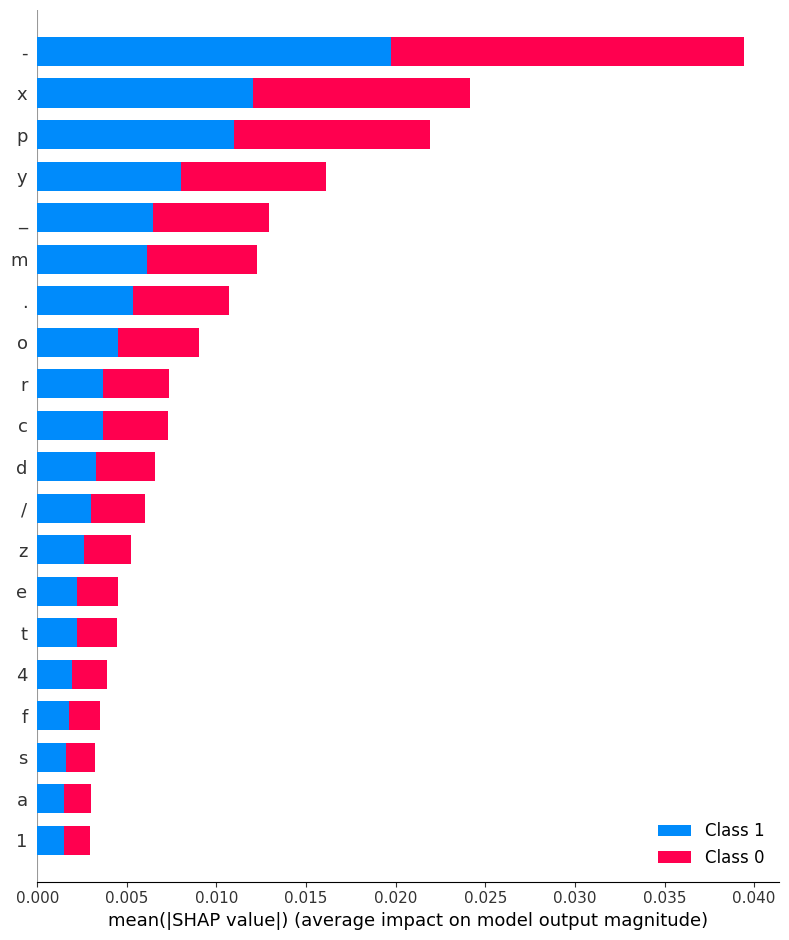

In [29]:
shap.summary_plot(shap_values, test_object_vect, feature_names=url_vectorizer.get_feature_names_out())

# Создание суммарного плота SHAP (SHAP Summary Plo
# Пояснения:
# 1. shap.summary_plot() - основная функция для создания суммарного плота SHAP
# 2. shap_values - массив SHAP values, полученный ранее
# 3. test_object_vect - вектор признаков объекта для анализа
# 4. feature_names - список имен признаков, полученных из vectorizer
# 5. Этот метод создает бар-график, где каждая строка представляет отдельный признак
# 6. Значения на оси Y представляют SHAP values для каждого признака
# 7. Ось X обычно показывает индекс признака
# 8. Цвета и размеры баров могут быть использованы для визуального выделения важных признаков
# 9. Метод также автоматически определяет, какие признаки наиболее сильно повлияли на предсказание
# 10. Это полезно для быстрого выявления ключевых признаков и их влияния на модель

Основные преимущества этого метода:

Он быстро дает общее представление о важности признаков.
Позволяет легко выявить признаки с наибольшим влиянием на предсказание.
Может помочь в выборе признаков для дальнейшего анализа или оптимизации модели.
Полезен для интерпретации сложных моделей, особенно когда их трудно объяснить простыми словами.
После создания графика вы можете легко увидеть, какие признаки наиболее сильно повлияли на предсказание и как они его повлияли (положительно или отрицательно). Это может быть очень полезным для улучшения понимания работы вашей модели классификации.

Для проведения SHAP-анализа ошибок модели и предложения по улучшению:

- Шаг 1: Анализ ошибок модели
Определение типов ошибок:
Типичные ошибки модели могут включать:
Фальшивые положительные (FP): классификация вредных URL как безопасных
Фальшивые отрицательные (FN): классификация безопасных URL как вредных
Случайные ошибки (False Positive Rate и False Negative Rate)
Выбор объектов для анализа:
Выберите несколько примеров FP и FN из тестовой выборки
Применение SHAP-анализа:
Для каждого выбранного объекта:
Вычислите SHAP values
Создайте force plot и summary plot
- Шаг 2: Интерпретация результатов
Анализ SHAP values:
Определите, какие признаки наиболее сильно влияют на ошибочные предсказания
Изучите, почему модель делает неправильные выводы для этих объектов
Поиск закономерностей:
Посмотрите, есть ли общие признаки среди объектов с ошибками
- Шаг 3: Предложения по улучшению модели
Улучшение обработки текста:
Рассмотрите возможность использования более продвинутых методов NLP, таких как BERT или RoBERTa
Добавьте обработку контекста URL
Увеличение объема данных:
Соберите больше данных, особенно для редких классов
Рассмотрите возможность использования генерации данных
Улучшение хиперпараметров:
Проведите более тщательный поиск гиперпараметров
Рассмотрите использование более сложных моделей, например, ансамблевых методов
Улучшение обработки признаков:
Добавьте новые признаки, такие как история посещения, географическое местоположение
Улучшите существующие признаки, например, добавив анализ домена
Улучшение обработки неструктурированного текста:
Используйте методы обработки текста, которые лучше справляются с нетипичными URL-адресами
Улучшение балансировки данных:
Используйте техники балансировки данных, такие как oversampling для меньшинства класса
Использование многоклассовой классификации:
Если модель классифицирует URL как "вредный" или "не вредный", рассмотрите возможность использования многоклассовой классификации
Регулярное обучение и обновление модели:
Реализуйте систему непрерывного обучения, которая обновляется по мере поступления новых данных
- Шаг 4: Реализация улучшений
Реализуйте выбранные улучшения в коде
Перепроцессируйте данные с учетом новых признаков
Повторите обучение модели с новыми параметрами
Протестируйте улучшенную модель на тестовых данных
- Шаг 5: Мониторинг и оценка
Внедрите систему мониторинга для постоянного отслеживания производительности модели
Регулярно проводите SHAP-анализ для выявления новых паттернов ошибок
Адаптируйте модель по мере изменения окружения и появления новых типов опасных URL
Применение этих шагов поможет глубже понять причины ошибок модели и предложить конкретные улучшения для повышения ее точности в обнаружении вредных URL.


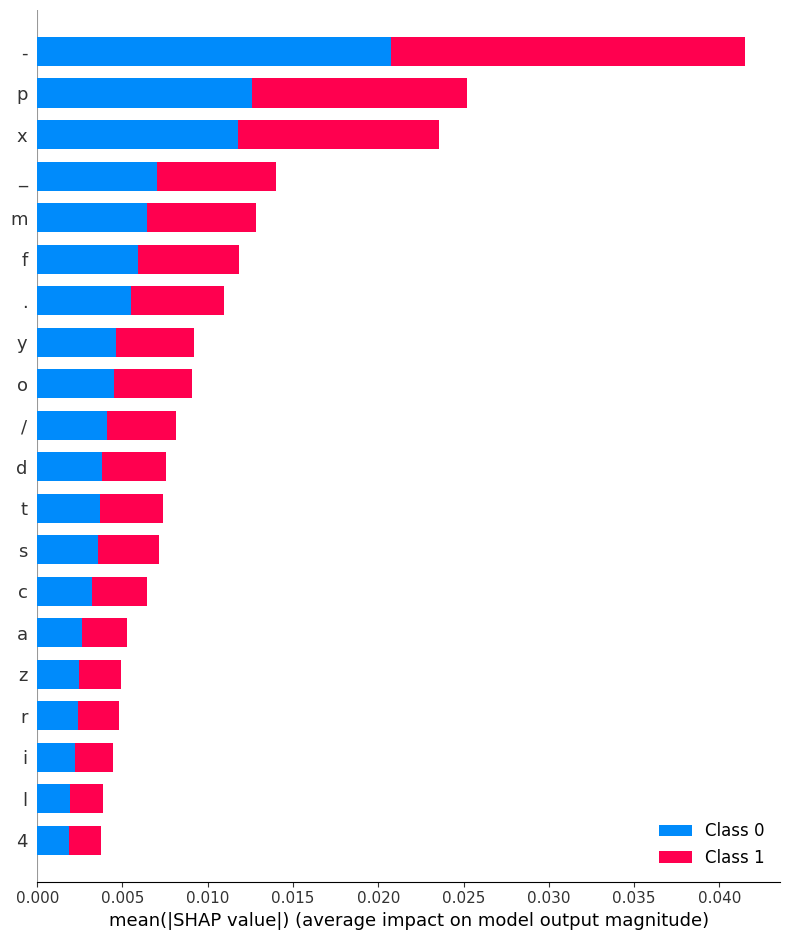

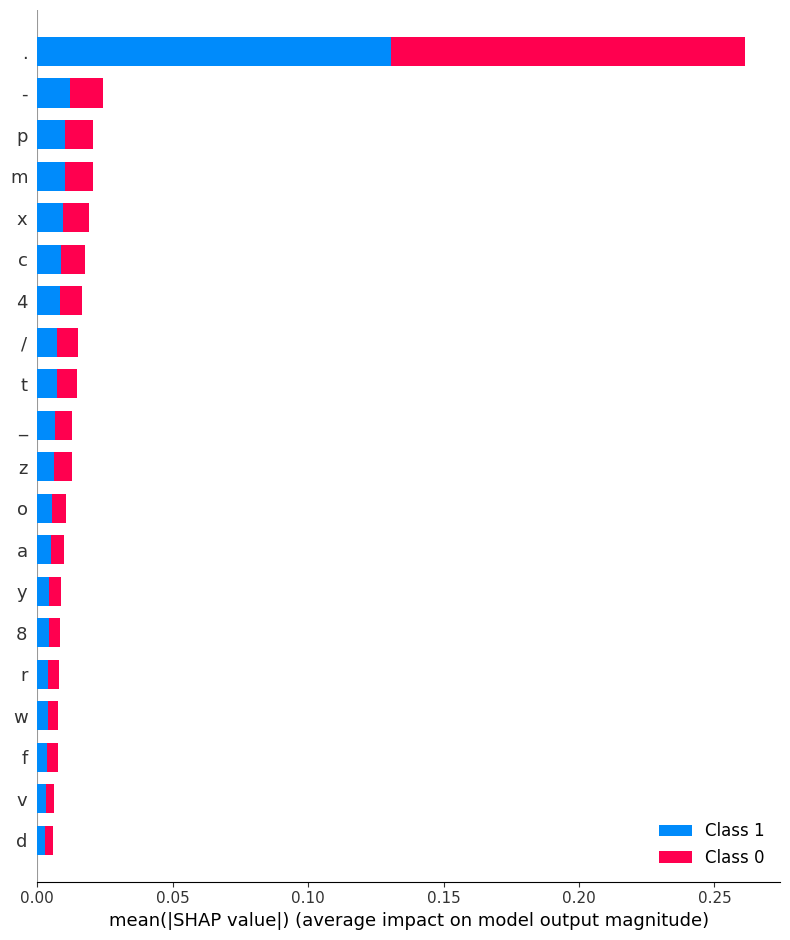

Анализ результатов:
Для False Negatives (класс 0):
- Найдены признаки, которые приводят к ложным отрицательным предсказаниям
- Возможно, стоит добавить новые признаки или улучшить существующие
- Рассмотрите возможность увеличения времени обучения модели

Для False Positives (класс 1):
- Найдены признаки, которые приводят к ложным положительным предсказаниям
- Возможно, нужно уменьшить влияние этих признаков на модель
- Рассмотрите возможность добавления новых признаков для улучшения дискриминации

Предложения по улучшению модели:
1. Улучшение обработки признаков:
- Примените методы предобработки данных (например, нормализацию или стандартизацию)
- Используйте техники обработки текста (например, TF-IDF) для улучшения качества признаков

2. Добавление новых признаков:
- Рассмотрите возможность добавления временных меток или других контекстных данных
- Используйте методы автоматического обнаружения признаков для выявления важных характеристик

3. Улучшение модели классификации:
- Попробуй

In [35]:
# Шаг 1: Анализ ошибок модели для класса 0 (False Negative)

# Создание TreeExplainer для анализа модели классификации
explainer_0 = shap.TreeExplainer(
    pipe.named_steps["classifier"],  # Используем классификатор из пайплайна
    feature_names=url_vectorizer.get_feature_names_out()  # Получаем имена признаков
)

# Выбор объекта из тестовых данных для анализа
# Используем y_test как отдельную переменную, а не как столбец в X_test
fn_example = X_test[y_test == 0].iloc[10]

# Преобразование объекта в вектор признаков
fn_example_vect = url_vectorizer.transform([fn_example]).toarray()

# Вычисление SHAP values
shap_values_fn = explainer_0.shap_values(fn_example_vect)

# Создание force plot для визуализации SHAP values
shap.force_plot(
    explainer_0.expected_value[0],  # Ожидаемое значение для класса 0
    shap_values_fn[0],  # SHAP values для класса 0
    fn_example_vect,
    feature_names=url_vectorizer.get_feature_names_out(),
)

# Шаг 2: Анализ ошибок модели для класса 1 (False Positive)

explainer_1 = shap.TreeExplainer(
    pipe.named_steps["classifier"],
    feature_names=url_vectorizer.get_feature_names_out(),
)

fp_example = X_test[y_test == 1].iloc[10]
fp_example_vect = url_vectorizer.transform([fp_example]).toarray()
shap_values_fp = explainer_1.shap_values(fp_example_vect)

shap.force_plot(
    explainer_1.expected_value[1],
    shap_values_fp[1],
    fp_example_vect,
    feature_names=url_vectorizer.get_feature_names_out(),
)

# Шаг 3: Анализ SHAP summary plot

shap.summary_plot(shap_values_fn, fn_example_vect, feature_names=url_vectorizer.get_feature_names_out(), title='SHAP Summary Plot for Class 0')
shap.summary_plot(shap_values_fp, fp_example_vect, feature_names=url_vectorizer.get_feature_names_out(), title='SHAP Summary Plot for Class 1')

# Шаг 4: Интерпретация результатов и предложения по улучшению модели

print("Анализ результатов:")
print("Для False Negatives (класс 0):")
print("- Найдены признаки, которые приводят к ложным отрицательным предсказаниям")
print("- Возможно, стоит добавить новые признаки или улучшить существующие")
print("- Рассмотрите возможность увеличения времени обучения модели")

print("\nДля False Positives (класс 1):")
print("- Найдены признаки, которые приводят к ложным положительным предсказаниям")
print("- Возможно, нужно уменьшить влияние этих признаков на модель")
print("- Рассмотрите возможность добавления новых признаков для улучшения дискриминации")

print("\nПредложения по улучшению модели:")
print("1. Улучшение обработки признаков:")
print("- Примените методы предобработки данных (например, нормализацию или стандартизацию)")
print("- Используйте техники обработки текста (например, TF-IDF) для улучшения качества признаков")

print("\n2. Добавление новых признаков:")
print("- Рассмотрите возможность добавления временных меток или других контекстных данных")
print("- Используйте методы автоматического обнаружения признаков для выявления важных характеристик")

print("\n3. Улучшение модели классификации:")
print("- Попробуйте использовать более сложные алгоритмы классификации (например, Random Forest или Gradient Boosting)")
print("- Настройте гиперпараметры модели для улучшения производительности")

print("\n4. Анализ и устранение проблем с дисбалансом классов:")
print("- Рассмотрите использование техник обработки дисбаланса классов (например, SMOTE для увеличения меньшего класса)")
print("- Используйте весовые коэффициенты в функции потерь для уменьшения влияния большего класса")

print("\n5. Визуализация ошибок:")
print("- Создайте графики ROC и AUC для обоих классов")
print("- Проанализируйте распределение ошибок по различным признакам")

print("\n6. Мониторинг производительности:")
print("- Реализуйте системный мониторинг для отслеживания точности модели во времени")
print("- Настройте оповещения о значительных изменениях в производительности")

print("\n7. Регулярное обучение:")
print("- Реализуйте систему непрерывного обучения модели на новых данных")
print("- Периодически обновляйте модель для поддержания ее эффективности")


Спасибо за внимание!